Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -22
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit for PEARLS violated - -21
Position limit f

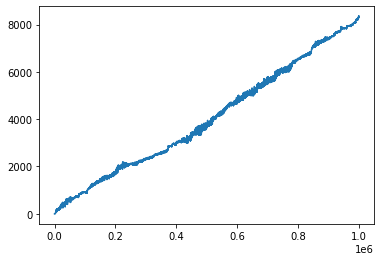

In [83]:
from basic_model import Trader
import matplotlib.pyplot as plt
import pandas as pd

from datamodel import *


def simulate(round: int, day: int, trader):
    historical_penal = list()
    prices_path = f"island-data-bottle-round-{round}/prices_round_{round}_day_{day}.csv"
    trades_path = f"island-data-bottle-round-{round}/trades_round_{round}_day_{day}_nn.csv"
    df_prices = pd.read_csv(prices_path, sep=';')
    df_trades = pd.read_csv(trades_path, sep=';')
    prev_time = -1
    state = TradingState(-1, {}, {}, {}, {}, {}, {})
    position = {}
    my_trades = {}
    market_trades = {}
    observations = {}
    last_prices = {}
    cash = 0
    pnl = 0
    for _, row in df_prices.iterrows():
        time = row["timestamp"]
        product = row["product"]
        if product not in position:
            position[product] = 0
            my_trades[product] = []
            market_trades[product] = []
        listing = {product: {"symbol": product,
                             "product": product, "denomination": product}}
        depth = {product: OrderDepth()}
        for i in range(1, 4):
            if row[f"bid_price_{i}"] > 0:
                depth[product].buy_orders[row[f"bid_price_{i}"]
                                          ] = row[f"bid_volume_{i}"]
            if row[f"ask_price_{i}"] > 0:
                depth[product].sell_orders[row[f"ask_price_{i}"]
                                           ] = row[f"ask_volume_{i}"]

        # process trades that happened at this time
        trades = df_trades[df_trades['timestamp'] == time]
        for _, trade in trades.iterrows():
            symbol = trade['symbol']
            if symbol != product:
                continue
            t = Trade(symbol, trade['price'], trade['quantity'],
                      trade['buyer'], trade['seller'], time)
            market_trades[product].append(t)

        if time != prev_time and prev_time != -1:
            state.timestamp = time
            output = trader.run(state)
            for product in output:
                for order in output[product]:  # process trader orders
                    levels = state.order_depths[order.symbol]
                    if order.quantity < 0:  # sell/ask - need corresponding buy
                        volume = abs(order.quantity)
                        while len(levels.buy_orders):
                            best_bid = max(levels.buy_orders.keys())
                            last_prices[product] = best_bid
                            if best_bid < order.price:
                                break  # if no overlap, skip
                            taken_volume = min(
                                volume, levels.buy_orders[best_bid])
                            volume -= taken_volume
                            levels.buy_orders[best_bid] -= taken_volume
                            position[product] -= taken_volume
                            cash += best_bid * taken_volume
                            my_trades[product].append(
                                Trade(product, best_bid, taken_volume, None, "self", prev_time))
                            if volume <= 0:
                                break
                            if levels.buy_orders[best_bid] <= 0:
                                del levels.buy_orders[best_bid]
                    else:  # buy / bid  - need corresponding sell
                        volume = abs(order.quantity)
                        while len(levels.sell_orders):
                            best_ask = min(levels.sell_orders.keys())
                            last_prices[product] = best_ask
                            if best_ask > order.price:
                                break  # if no overlap, skip
                            taken_volume = min(
                                volume, levels.sell_orders[best_ask])
                            volume -= taken_volume
                            levels.sell_orders[best_ask] -= taken_volume
                            position[product] += taken_volume
                            cash -= best_ask * taken_volume
                            my_trades[product].append(
                                Trade(product, best_ask, taken_volume, "self", None, prev_time))
                            if volume <= 0:
                                break
                            if levels.sell_orders[best_ask] <= 0:
                                del levels.sell_orders[best_ask]
            state = TradingState(
                time, listing, depth, my_trades, market_trades, position, observations)
        else:
            state.listings[product] = listing[product]
            state.order_depths[product] = depth[product]

        for product in position:
            if abs(position[product]) > 20:
                print(
                    f"Position limit for {product} violated - {position[product]}")
                # raise RuntimeError()
        pnl = cash + sum(position[product] * last_prices[product]
                         if product in last_prices else 0 for product in position)
        historical_penal.append(pnl)
        prev_time = time
    print(pnl, (cash, position))
    plt.plot(df_prices["timestamp"], historical_penal)
    plt.show()


simulate(1, 0, Trader())
